### Principal Components Analysis

In [58]:
import os
import numpy as np
import pandas as pd
import random as rd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy

### Functions

In [2]:
def biplot(df_scores: pd.DataFrame, df_loadings: pd.DataFrame, annotate_observations: bool = True):
    """
    Plot a biplot Principal Components Scores and Loading Vectors.
    
    Inputs
    -------
    df_scores(pd.DatFrame):
        DataFrame with Principal Components Scores in the columns.
    
    df_loadings(pd.DataFrame):
        DataFrame with Loading Vectors in the columns.
        
    annotate_observations(bool):
        If True the loading vectors will be annotated with its names, default True.
    """
    fig , ax1 = plt.subplots(figsize = (9,7))

    # Set Limits 
    scores_max = df_scores[["PC1", "PC2"]].max()
    scores_min = df_scores[["PC1", "PC2"]].min()
    ax1_x_max = np.abs(scores_max["PC1"])
    ax1_y_max = np.abs(scores_max["PC2"])
    ax1_x_min = np.abs(scores_min["PC1"])
    ax1_y_min = np.abs(scores_min["PC2"])
    ax1_abs_max = np.max([ax1_x_max, ax1_y_max, ax1_x_min, ax1_y_min]) + 1
    
    ax1.set_xlim(-ax1_abs_max, ax1_abs_max) 
    ax1.set_ylim(-ax1_abs_max, ax1_abs_max)

    # Plot First Two Principal Components
    if annotate_observations:
        for i in df_scores.index:
            ax1.annotate(i, (df_scores["PC1"][i], -df_scores["PC2"][i]), ha = 'center')
    else:
        ax1.scatter(x = df_scores["PC1"], y = df_scores["PC2"])

    # Add PC Labels
    ax1.set_xlabel('First Principal Component')
    ax1.set_ylabel('Second Principal Component')

    # Plot reference lines
    ax1.axhline(y = 0, linestyle = 'dotted', color = 'grey')
    ax1.axvline(x = 0, linestyle = 'dotted', color = 'grey')

    # Plot Principal Component loading vectors, using a second y-axis.
    ax2 = ax1.twinx().twiny() 

    ax2.set_ylim(-1, 1)
    ax2.set_xlim(-1, 1)
    ax2.tick_params(axis = 'y', colors = 'red')
    ax2.set_xlabel('Principal Component loading vectors', color = 'red')

    # Plot Loading vectors
    b = 1.07 # to put the annotate a little away from the arrow
    for i in df_loadings.index:
        ax2.annotate(i, (df_loadings["V1"][i]*b, -df_loadings["V2"][i]*b), color = 'red')
        ax2.arrow(0, 0, pca_loadings["V1"][i], -pca_loadings["V2"][i])

    plt.show()

### Lab

In [3]:
# Data Path
root_path = os.getcwd()
data_path = os.path.join(root_path, "data")

usa_arrests_path = os.path.join(data_path, "USArrests.csv")

In [4]:
# Load Data
USArrests = pd.read_csv(usa_arrests_path)
USArrests.columns = ["State"] + USArrests.columns.tolist()[1:]
USArrests = USArrests.set_index("State")
USArrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [5]:
# Get Satates
states = USArrests.index.tolist()

In [6]:
# Get Columns
USArrests.columns

Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

In [7]:
# Very Different Means
USArrests.mean(axis = 0)

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [8]:
# Very Different Std
USArrests.std(axis = 0)

Murder       4.355510
Assault     83.337661
UrbanPop    14.474763
Rape         9.366385
dtype: float64

In [9]:
# StandardScaler and PCA
pca_pipeline = Pipeline(steps = [
    ("Scaler", StandardScaler()),
    ("PCA", PCA())
])

pca_usa_arrests = pca_pipeline.fit_transform(USArrests)

In [10]:
# Mean
pca_pipeline.named_steps["Scaler"].mean_

array([  7.788, 170.76 ,  65.54 ,  21.232])

In [11]:
# Std
pca_pipeline.named_steps["Scaler"].scale_

array([ 4.31173469, 82.50007515, 14.3292847 ,  9.27224762])

In [12]:
# Matrix where each ROW is Principal Component Loading
pca_loadings = pca_pipeline.named_steps["PCA"].components_
pca_loadings = pd.DataFrame(pca_loadings.T, index = USArrests.columns, columns = ['V1', 'V2', 'V3', 'V4'])
pca_loadings

,V1,V2,V3,V4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


In [13]:
# Principal Components Scores 
pca_scores = pd.DataFrame(pca_usa_arrests, index = USArrests.index, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
pca_scores

,PC1,PC2,PC3,PC4
State,,,,
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996
Colorado,1.514563,-0.987555,1.095007,0.001465
Connecticut,-1.358647,-1.088928,-0.643258,-0.118469
Delaware,0.047709,-0.325359,-0.718633,-0.881978
Florida,3.013042,0.039229,-0.576829,-0.096285


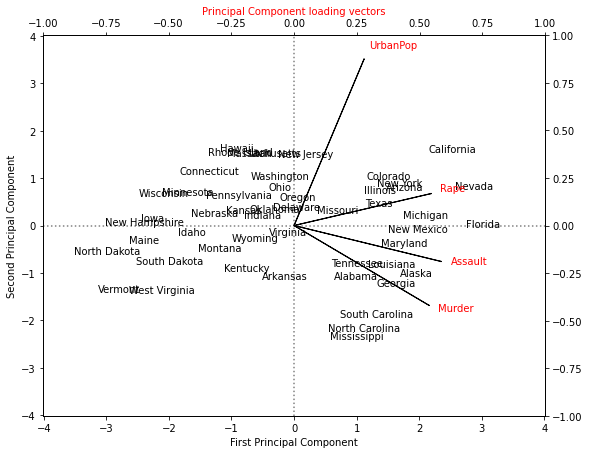

In [14]:
# Biplot
biplot(df_scores = pca_scores, df_loadings = pca_loadings)

In [15]:
# Explained Variance
pca_pipeline.named_steps["PCA"].explained_variance_ 

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [16]:
# Proportion of Variance Explained
pve = pca_pipeline.named_steps["PCA"].explained_variance_ratio_
cumsum_pve = np.cumsum(pve)

In [17]:
# %PVE Data Frame
pd.DataFrame(pve, index = ['PC1', 'PC2', 'PC3', 'PC4'], columns = ["%PVE"]).T

,PC1,PC2,PC3,PC4
%PVE,0.62006,0.247441,0.089141,0.043358


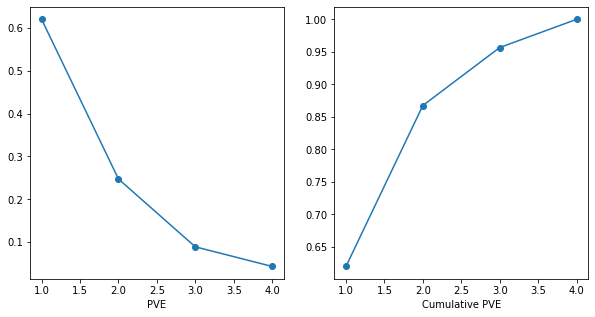

In [18]:
# Plot PVE
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot([1,2,3,4], pve, '-o')
ax[1].plot([1,2,3,4], cumsum_pve, '-o')
ax[0].set_xlabel("Principal Component")
ax[0].set_xlabel("PVE")
ax[1].set_xlabel("Cumulative PVE")
plt.show()

### Matrix Completion

In [19]:
# Load Data
USArrests = pd.read_csv(usa_arrests_path)
USArrests.columns = ["State"] + USArrests.columns.tolist()[1:]
USArrests = USArrests.set_index("State")
USArrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [20]:
# %PVE Data Frame
pd.DataFrame(pve, index = ['PC1', 'PC2', 'PC3', 'PC4'], columns = ["%PVE"]).T

,PC1,PC2,PC3,PC4
%PVE,0.62006,0.247441,0.089141,0.043358


In [21]:
# StandardScaler and SVD
scaler = StandardScaler()
USArrests_scaled = scaler.fit_transform(USArrests)
svd_u, svd_sig, svd_vt = np.linalg.svd(USArrests_scaled)

The matrix $v$ is equivalent to the loading matrix from principal components (up to an unimportant sign flip).

In [22]:
# V -> Loading Matrix
np.round(svd_vt.T, 3)

array([[-0.536,  0.418, -0.341,  0.649],
       [-0.583,  0.188, -0.268, -0.743],
       [-0.278, -0.873, -0.378,  0.134],
       [-0.543, -0.167,  0.818,  0.089]])

In [23]:
# Loadings From PCA
pca_loadings = pca_pipeline.named_steps["PCA"].components_
pca_loadings = pd.DataFrame(pca_loadings.T, index = USArrests.columns, columns = ['V1', 'V2', 'V3', 'V4'])
np.round(pca_loadings, 3)

,V1,V2,V3,V4
Murder,0.536,0.418,-0.341,0.649
Assault,0.583,0.188,-0.268,-0.743
UrbanPop,0.278,-0.873,-0.378,0.134
Rape,0.543,-0.167,0.818,0.089


The matrix $u$ is equivalent to the matrix of standardized scores, and the standard deviations are in the vector $d = svd\_sig$. We can recover the score vectors using the output of *np.linalg.svd*. They are identical to the score vectors output by *PCA()*.

In [24]:
# Get "u" and "d" Matrices
u = svd_u[:, :4]
d = np.diagflat(svd_sig[:4])
svd_score_vectors = u @ d

In [25]:
pd.DataFrame(svd_score_vectors).head()

,0,1,2,3
0,-0.985566,1.133392,-0.444269,0.156267
1,-1.950138,1.073213,2.040003,-0.438583
2,-1.763164,-0.745957,0.054781,-0.834653
3,0.141420,1.119797,0.114574,-0.182811
4,-2.523980,-1.542934,0.598557,-0.341996


In [26]:
pca_scores.head()

,PC1,PC2,PC3,PC4
State,,,,
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


We now omit 20 entries in the 50 × 2 data matrix at random. We do so by first selecting 20 rows (states) at random, and then selecting one of the four entries in each row at random.

In [27]:
# Place Random Missinges
USArrests_scaled_missings = USArrests_scaled.copy()

n_omit = 20
rd.seed(12345)
random_rows = rd.sample(range(50), n_omit)
random_columns = rd.choices(range(4), k = n_omit)
for index in zip(random_rows, random_columns):
    USArrests_scaled_missings[index] = np.nan

In [28]:
USArrests_scaled_missings

array([[ 1.25517927,  0.79078716,         nan, -0.00345116],
       [ 0.51301858,  1.11805959, -1.22406668,  2.50942392],
       [ 0.07236067,  1.49381682,  1.00912225,  1.05346626],
       [ 0.23470832,  0.23321191, -1.08449238, -0.18679398],
       [ 0.28109336,  1.2756352 ,  1.77678094,  2.08881393],
       [ 0.02597562,         nan,  0.86954794,  1.88390137],
       [-1.04088037, -0.73648418,  0.79976079, -1.09272319],
       [-0.43787481,  0.81502956,         nan, -0.58583422],
       [ 1.76541475,  1.99078607,  1.00912225,  1.1505301 ],
       [ 2.22926518,  0.48775713, -0.38662083,  0.49265293],
       [-0.57702994, -1.51224105,  1.21848371,         nan],
       [-1.20322802, -0.61527217, -0.80534376,         nan],
       [        nan,  0.94836277,  1.21848371,  0.29852525],
       [-0.13637203, -0.70012057, -0.03768506, -0.0250209 ],
       [-1.29599811, -1.39102904, -0.5959823 , -1.07115345],
       [-0.41468229, -0.67587817,  0.03210209, -0.34856705],
       [ 0.44344101, -0.

We are going to implement Algorithm 12.1

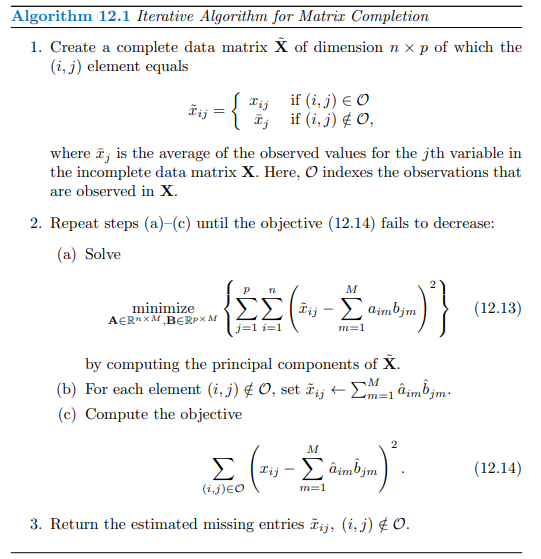

In [29]:
# Step 1
def fill_na(X: np.array, fill_with: str = "mean") -> list[np.array]:
    """
    This function fill the na values of an array.
    
    Inputs
    -------
    X(np.array):
        Array to which the missing values are to be filled in.
        
    Returns
    -------
    (np.array):
        Array with the missing values filled with fill_with.
    (np.array):
        Bool Array, Each entry is True if the field was NaN value else False.
    (np.array):
        Array with the means of each X column. 
    """
    imputer = SimpleImputer(strategy = fill_with)
    X_filled = imputer.fit_transform(X)
    index_isnan = np.isnan(X)
    X_means = imputer.statistics_
    
    return [X_filled, index_isnan, X_means]

In [30]:
# Step 2(a)
def fit_svd(X: np.array, M: int = 1):
    """
    This Function Aproximates the matrix X with SVD.
    
    Inputs
    -------
    X(np.array): 
        Scaled and Centered Matrix.
    M(int):
        Number of components to be used, default 1.
    """
    svd_u, svd_sig, svd_vt = np.linalg.svd(X)
    u = svd_u[:, :M]
    d = np.diagflat(svd_sig[:M])
    svd_score_vectors = u @ d
    svd_loading_vectors = svd_vt[:M, :]
    
    return svd_score_vectors @ svd_loading_vectors

In [31]:
# Step 1
X_filled, index_isnan, X_means = fill_na(USArrests_scaled_missings)

# Set initial Parameters
tresh = 1e-7
iteration = 1 
relative_error = 1
mssold = np.mean((X_filled - X_means)[~index_isnan]**2)
mss0 = np.mean(X_filled[~index_isnan]**2)

# Step 2
while relative_error > tresh:
    iteration += 1
    
    # Step 2(a)
    X_app_svd = fit_svd(X = X_filled, M = 1)
    
    # Step 2(b)
    X_filled[index_isnan] = X_app_svd[index_isnan]
    
    # Step 2(c)
    mss = np.mean((X_filled - X_app_svd)[~index_isnan]**2)
    relative_error = (mssold - mss)/mss0
    mssold = mss
    
    print("Iter: " + str(iteration), "MSS:" + str(mss), "Rel. Err:" +  str(relative_error), "\n")

Iter: 2 MSS:0.3943404865041043 Rel. Err:0.6239056542895383 

Iter: 3 MSS:0.38151326145586023 Rel. Err:0.012196545545332818 

Iter: 4 MSS:0.38003312125206035 Rel. Err:0.0014073657662687321 

Iter: 5 MSS:0.37981480330857603 Rel. Err:0.0002075838484984198 

Iter: 6 MSS:0.3797757926254955 Rel. Err:3.709263470133891e-05 

Iter: 7 MSS:0.3797679131953016 Rel. Err:7.4920202046309765e-06 

Iter: 8 MSS:0.37976621456446097 Rel. Err:1.6151138172752404e-06 

Iter: 9 MSS:0.3797658366729899 Rel. Err:3.593115830302512e-07 

Iter: 10 MSS:0.37976575135346624 Rel. Err:8.112459650569664e-08 



In [32]:
# Step 3
print(USArrests_scaled[index_isnan])
print(X_filled[index_isnan])

[-0.52619514  0.40290872  0.45082502 -0.11129987 -0.75839217  0.60578867
 -0.53190987  0.94836277  0.81452136 -1.1800355  -1.5032153  -0.51034012
  0.98472638 -0.11317951 -0.13286962 -0.66980002  1.25517927  0.46029832
 -0.05737552 -0.31224214]
[ 0.36948611  1.21621175 -0.0167741  -0.6369978  -0.93956756  0.74205662
 -0.3950436   0.89304243  0.91318831 -0.72715619  0.45832283 -0.75664749
  2.14497429 -0.10672311 -0.17731276  0.28192695  0.21480298  0.84757228
 -0.06008979  0.0065903 ]


In [33]:
# Pearson's r
np.corrcoef(USArrests_scaled[index_isnan], X_filled[index_isnan])

array([[1.        , 0.60532835],
       [0.60532835, 1.        ]])

**Note**: In this lab, we implemented Algorithm 12.1 ourselves for didactic purposes.
However, a reader who wishes to apply matrix completion to theirdata should use the softImpute package on CRAN, 
which provides a very softImpute efficient implementation of a generalization of this algorithm. softImpute is implemented in R.

### Clustering: K-means

We start with simulated values.

In [35]:
# Simulated Values
np.random.seed(42)

x = np.random.normal(size = 50*2).reshape(50, 2)
x[0:25, 0] += 3
x[25:50, 1] -= 4

In [37]:
# Fit K-means
kmeans = KMeans(n_clusters = 2, random_state = 42, n_init = 20)
kmeans.fit(x)

KMeans(n_clusters=2, n_init=20, random_state=42)

In [39]:
# Labels Clusters
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

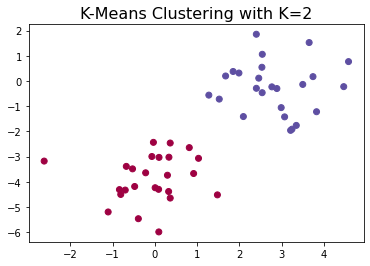

In [41]:
plt.scatter(x[:, 0], x[:, 1], c = kmeans.labels_, cmap = 'Spectral')
plt.title('K-Means Clustering with K=2', size = 16);

In [43]:
kmeans2 = KMeans(n_clusters = 3, random_state = 42, n_init = 20)
kmeans2.fit(x)

KMeans(n_clusters=3, n_init=20, random_state=42)

In [44]:
kmeans2.cluster_centers_

array([[ 2.60450418,  0.24696837],
       [-0.09155989, -3.87287837],
       [ 3.27858059, -1.37217166]])

In [46]:
kmeans2.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [47]:
kmeans3 = KMeans(n_clusters = 3, random_state = 42, n_init = 1)
kmeans3.fit(x)
kmeans4 = KMeans(n_clusters = 3, random_state = 42, n_init = 20)
kmeans4.fit(x)

print('inertia with n_init=1:', kmeans3.inertia_)
print('inertia with n_init=20:', kmeans4.inertia_)

inertia with n_init=1: 63.375640833186544
inertia with n_init=20: 62.73737809735572


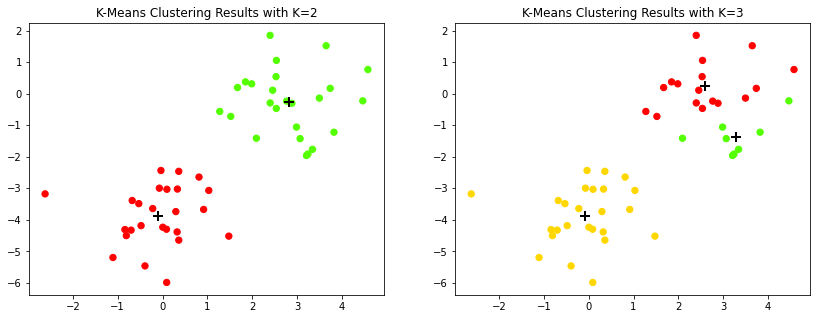

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.scatter(x[:, 0], x[:, 1], s = 40, c = kmeans.labels_, cmap = plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker = '+', s = 100, c = 'k', linewidth = 2)

ax2.scatter(x[:, 0], x[:, 1], s = 40, c = kmeans4.labels_, cmap = plt.cm.prism) 
ax2.set_title('K-Means Clustering Results with K=3')
ax2.scatter(kmeans4.cluster_centers_[:, 0], kmeans4.cluster_centers_[:, 1], marker = '+', s = 100, c = 'k', linewidth = 2);

### Clustering: Hierarchical Clustering

In [59]:
# Hierarchical Clustering with Different Linkages
hc_complete = hierarchy.linkage(x, method = 'complete')
hc_average = hierarchy.linkage(x, method = 'average')
hc_single = hierarchy.linkage(x, method = 'single')

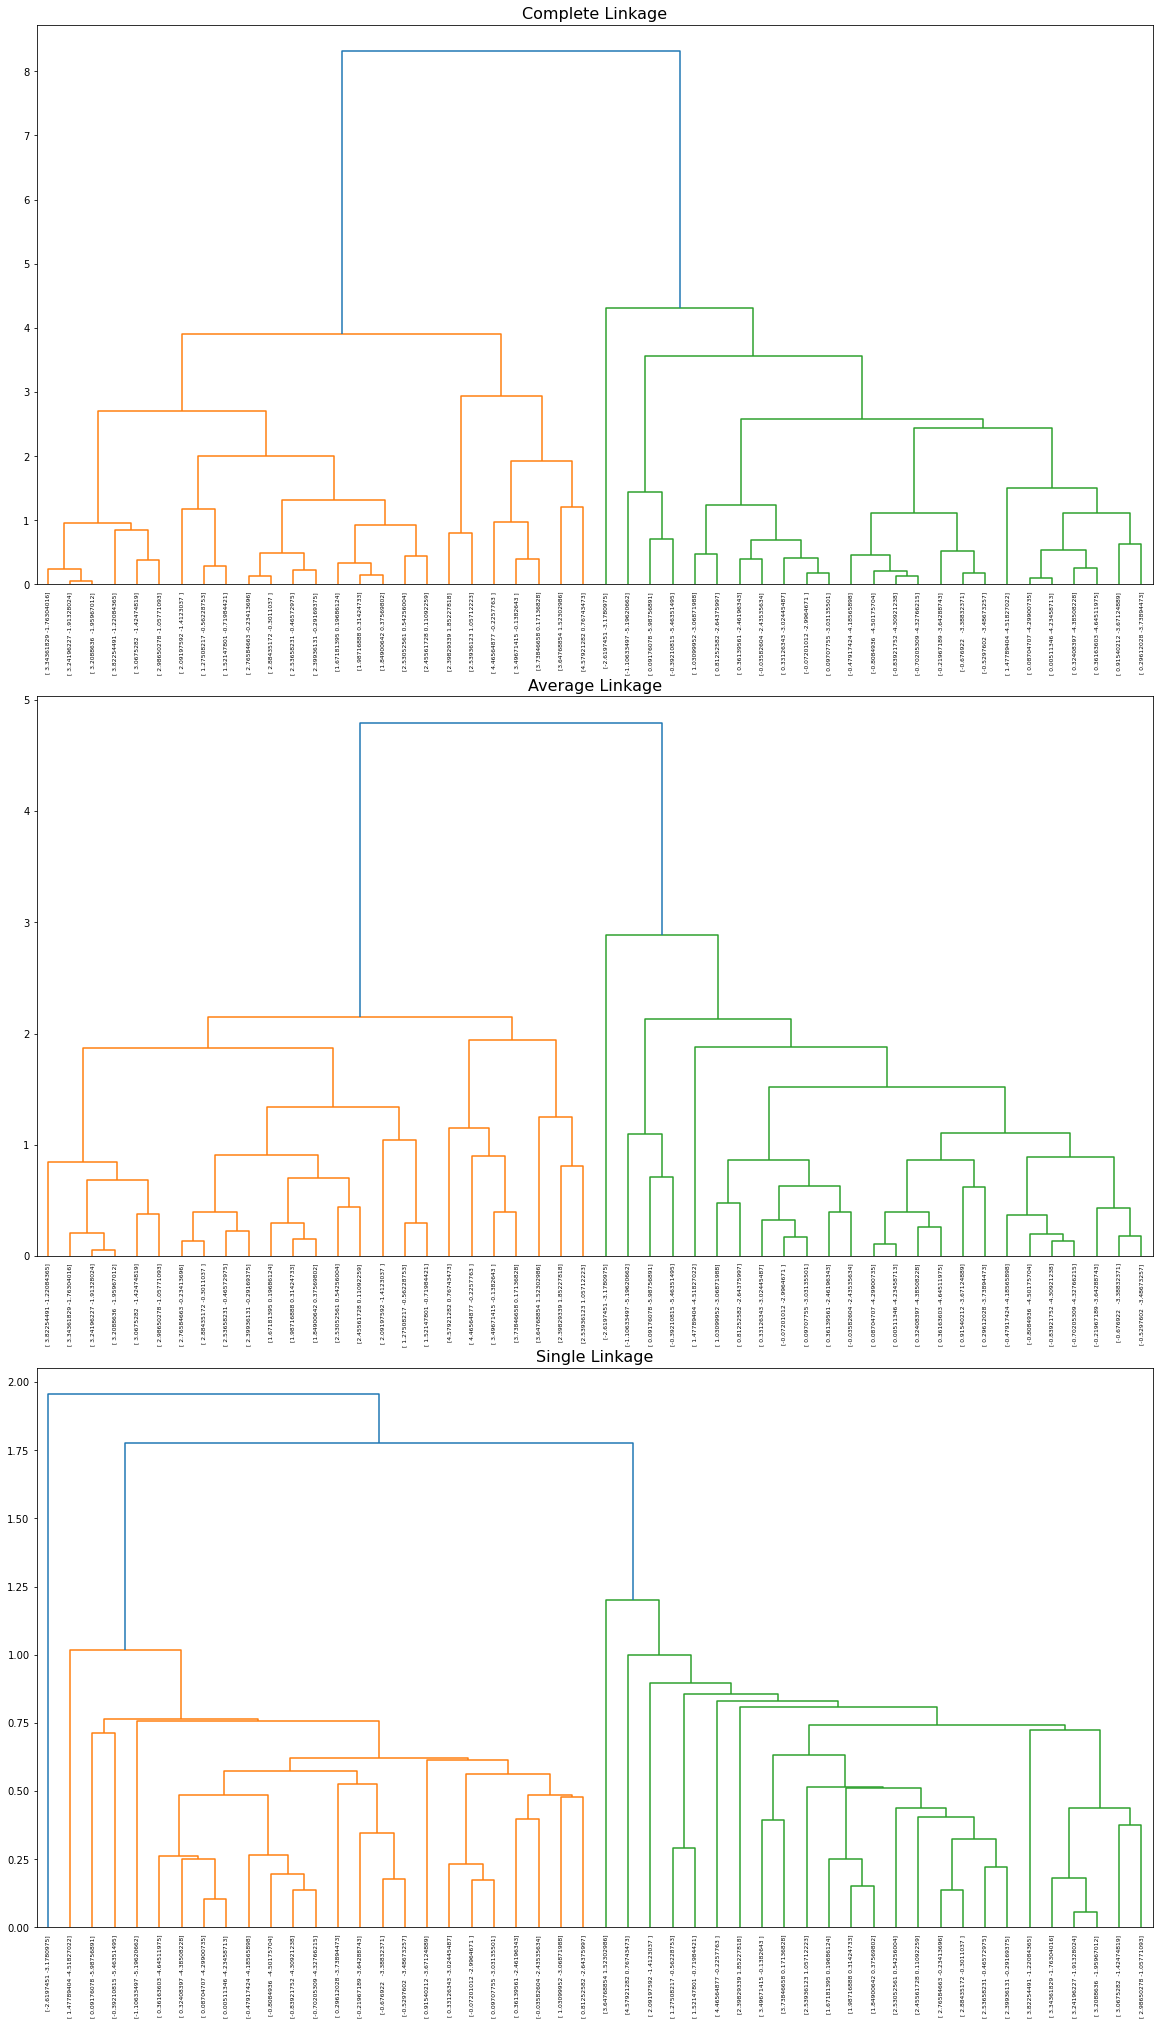

In [70]:
# Plot Dendograms
f, axes = plt.subplots(3, 1, sharex = False, sharey = False)

f.set_figheight(35)
f.set_figwidth(20)

dendrogram(hc_complete,
           labels = x,
           leaf_rotation = 90,
           leaf_font_size = 6,
           ax = axes[0])

dendrogram(hc_average,
           labels = x,
           leaf_rotation = 90,
           leaf_font_size = 6,
           ax = axes[1])

dendrogram(hc_single,
           labels = x,
           leaf_rotation = 90,
           leaf_font_size = 6,
           ax = axes[2])

axes[0].set_title('Complete Linkage', size=16)
axes[1].set_title('Average Linkage', size=16)
axes[2].set_title('Single Linkage', size=16);

In [72]:
hierarchy.cut_tree(hc_complete, 2).ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [73]:
hierarchy.cut_tree(hc_average, 2).ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [74]:
hierarchy.cut_tree(hc_single, 2).ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [75]:
hierarchy.cut_tree(hc_single, 4).ravel()

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

C:\Users\w10\Documents\Entornos\ds\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


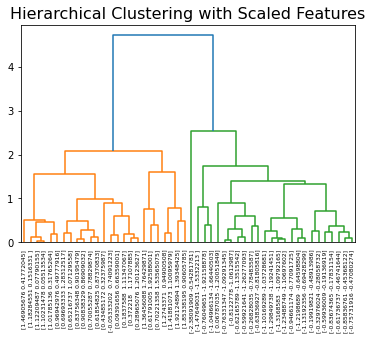

In [78]:
# Hierarchical Clustering with Scaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

dendrogram(linkage(x_scaled, method = 'complete'),
           labels = x_scaled,
           leaf_rotation = 90,
           leaf_font_size = 6)

plt.title('Hierarchical Clustering with Scaled Features', size=16);

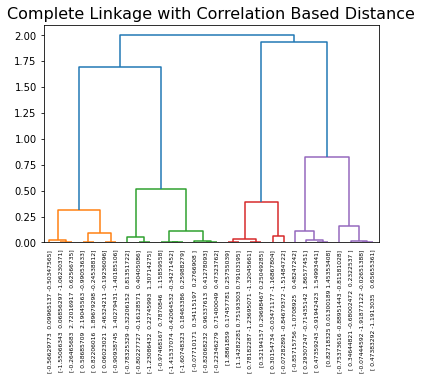

In [79]:
# Hierarchical Clustering with Correlation as Dissimilarity Measure
x = np.random.normal(size = 30*3).reshape(30, 3)

# scipy linkage takes care of the distance function pdist
dendrogram(linkage(x, method = 'complete', metric = 'correlation'),
           labels = x,
           leaf_rotation = 90,
           leaf_font_size = 6)

plt.title('Complete Linkage with Correlation Based Distance', size = 16);

### NCI60 Data Example

#### PCA

In [110]:
# Load Data
nci_raw = sm.datasets.get_rdataset("NCI60", "ISLR").data
nci_labs = nci_raw["labs"]
nci_data = nci_raw.iloc[:, :-1]
nci_labs_codes = nci_labs.astype("category").cat.codes

In [90]:
nci_data.shape

(64, 6830)

In [93]:
nci_labs.shape

(64,)

In [94]:
nci_labs.value_counts()

RENAL          9
NSCLC          9
MELANOMA       8
BREAST         7
COLON          7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
UNKNOWN        1
K562B-repro    1
K562A-repro    1
MCF7A-repro    1
MCF7D-repro    1
Name: labs, dtype: int64

In [95]:
# StandardScaler and PCA
pca_pipeline = Pipeline(steps = [
    ("scaler", StandardScaler()),
    ("PCA", PCA())
])

pca_nci = pca_pipeline.fit_transform(nci_data)

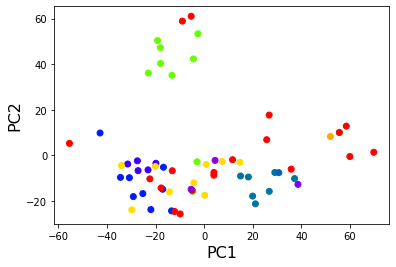

In [116]:
# Plot PC1 and PC2
plt.scatter(pca_nci[:, 0], pca_nci[:, 1], c = nci_labs_codes.values, cmap =  plt.cm.prism)
plt.xlabel('PC1', size = 16);
plt.ylabel('PC2', size = 16);

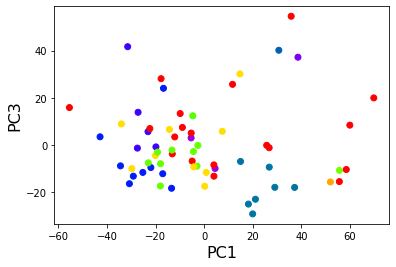

In [118]:
# Plot PC1 and PC3
plt.scatter(pca_nci[:, 0], pca_nci[:, 3], c = nci_labs_codes.values, cmap =  plt.cm.prism)
plt.xlabel('PC1', size = 16);
plt.ylabel('PC3', size = 16);

In [121]:
# PVE
pve = pca_pipeline.named_steps["PCA"].explained_variance_ratio_
cumsum_pve = np.cumsum(pve)

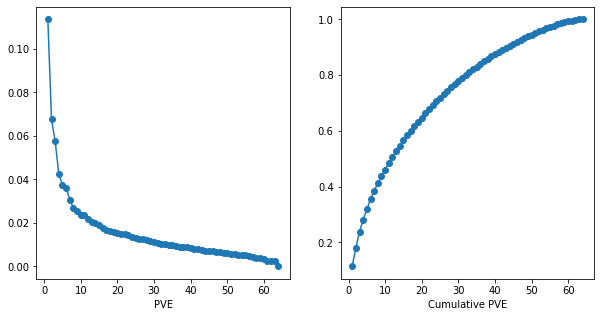

In [125]:
# Plot PVE
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(range(1, pve.shape[0] + 1), pve, '-o')
ax[1].plot(range(1, cumsum_pve.shape[0] + 1), cumsum_pve, '-o')
ax[0].set_xlabel("Principal Component")
ax[0].set_xlabel("PVE")
ax[1].set_xlabel("Cumulative PVE")
plt.show()

#### Clustering

In [126]:
# Scaled Data
scaler = StandardScaler()
nci_data_scaled = scaler.fit_transform(nci_data)

In [127]:
# Hierarchical Clustering with Different Linkages
hc_complete = hierarchy.linkage(nci_data_scaled, method = 'complete')
hc_average = hierarchy.linkage(nci_data_scaled, method = 'average')
hc_single = hierarchy.linkage(nci_data_scaled, method = 'single')

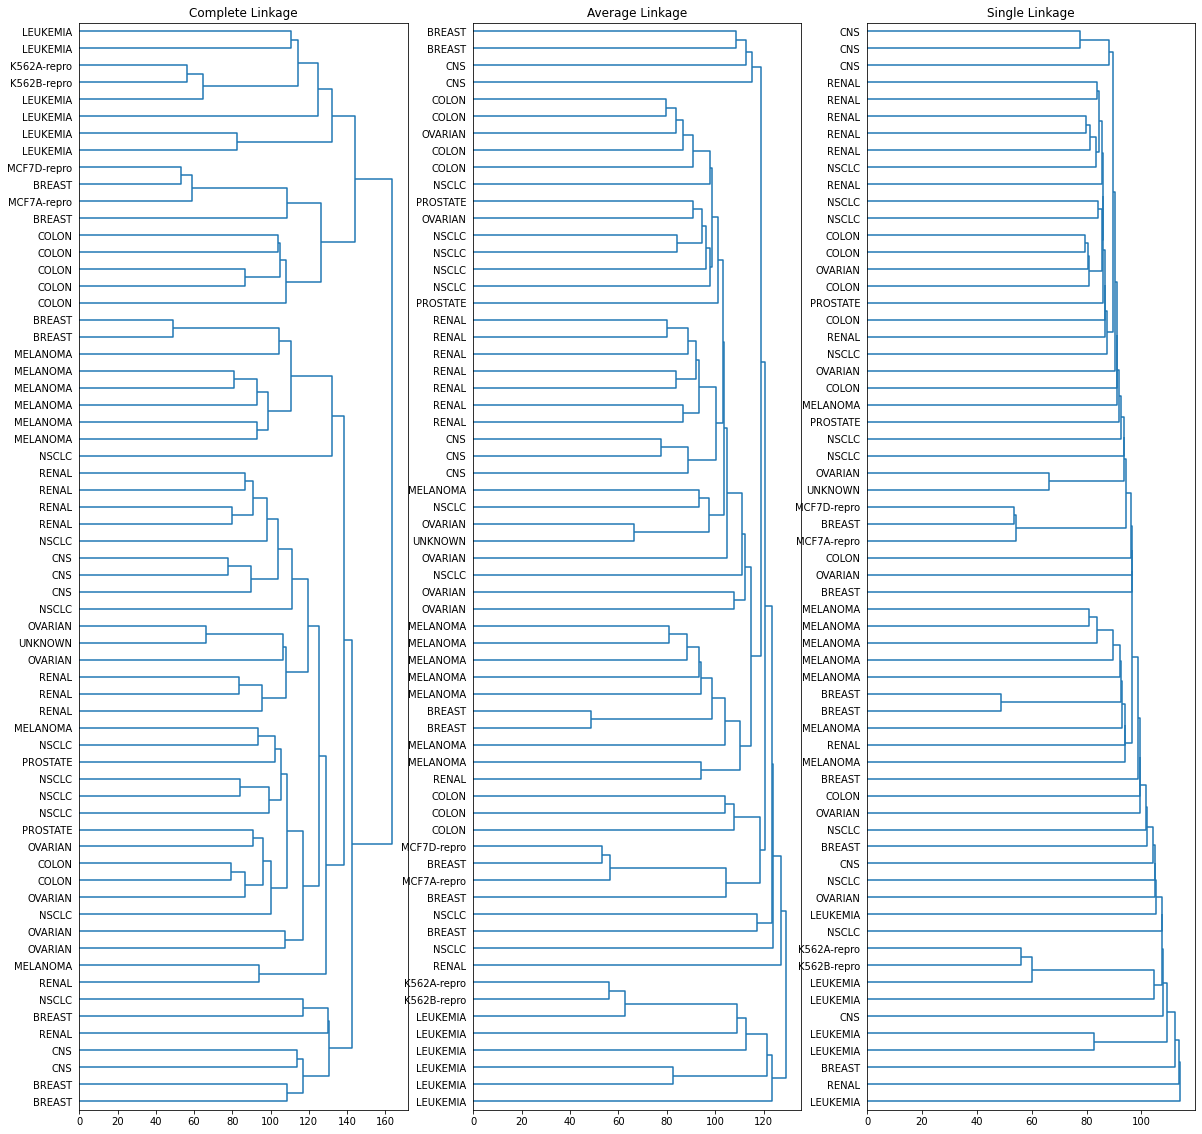

In [138]:
# Plot Dendograms
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hc_complete, hc_average, hc_single],
                                ['c1','c2','c3'],
                                [ax1, ax2, ax3]):
    cluster = hierarchy.dendrogram(linkage, labels = nci_labs.values, orientation = 'right', color_threshold = 0, leaf_font_size = 10, ax = ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');

In [149]:
# Cut for 4 Clusters
labs_4_clusters = hierarchy.cut_tree(hc_complete, 4).ravel()

In [150]:
pd.DataFrame({"Cluster": labs_4_clusters, "Labels": nci_labs.values})

,Cluster,Labels
0,0,CNS
1,0,CNS
2,0,CNS
3,0,RENAL
4,1,BREAST
...,...,...
59,0,MELANOMA
60,0,MELANOMA
61,0,MELANOMA
62,0,MELANOMA


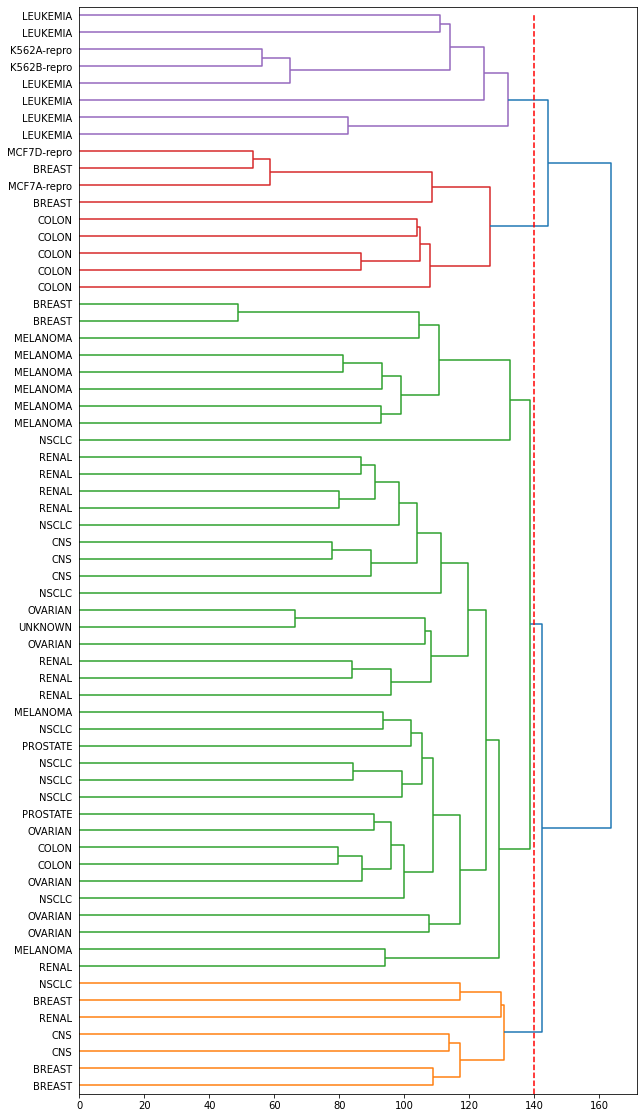

In [154]:
plt.figure(figsize=(10,20))
cut4 = hierarchy.dendrogram(hc_complete,
                            labels = nci_labs.values, orientation = 'right', color_threshold = 140, leaf_font_size = 10)
plt.vlines(140, 0, plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles = 'dashed');

In [163]:
# Fit K-means
kmeans = KMeans(n_clusters = 4, random_state = 42, n_init = 20)
kmeans.fit(nci_data)

KMeans(n_clusters=4, n_init=20, random_state=42)

In [164]:
# K-means Clusters
pd.Series(kmeans.labels_).value_counts().sort_index()

0    19
1    28
2     9
3     8
dtype: int64

In [165]:
# Hierarchical Clustering
pd.Series(labs_4_clusters).value_counts().sort_index()

0    40
1     7
2     8
3     9
dtype: int64

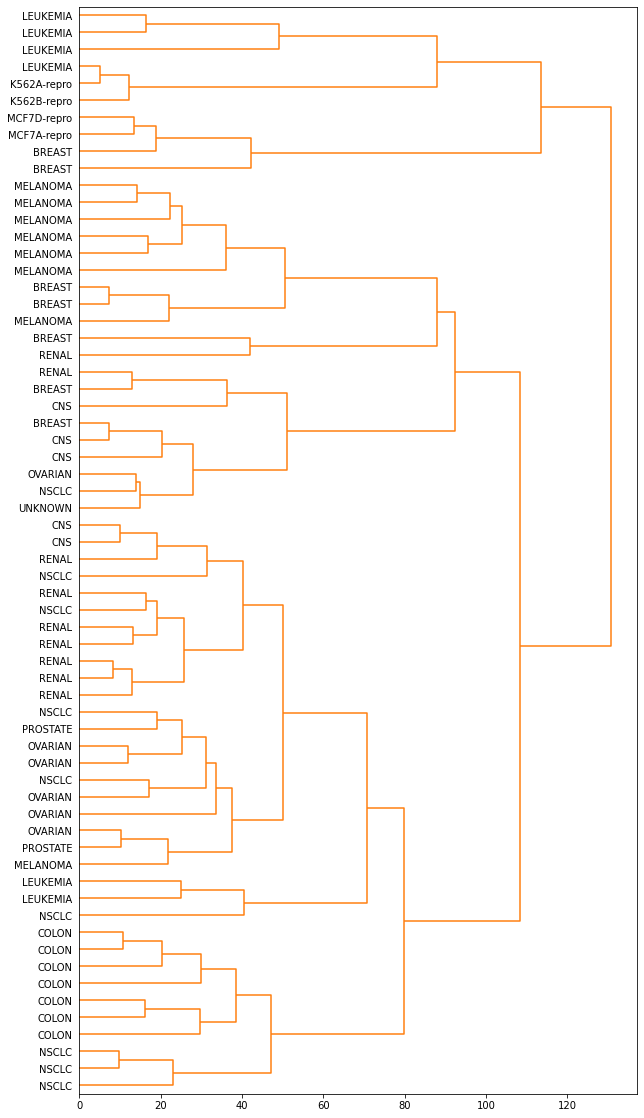

In [170]:
# Hierarchical Clustering in five two PC
hc_complete = hierarchy.linkage(pca_nci[: , :5], method = 'complete')
plt.figure(figsize=(10,20))
_ = hierarchy.dendrogram(hc_complete,
                     labels = nci_labs.values, 
                     orientation = 'right', 
                     color_threshold = 140, 
                     leaf_font_size = 10)

In [173]:
pd.Series(hierarchy.cut_tree(hc_complete, 4).ravel()).value_counts()

0    34
1    20
2     6
3     4
dtype: int64